# <a id='toc6_'></a>[4 Modelling](#toc0_)

## <a id='toc6_1_'></a>[](#toc0_)

es gibt bei Empfehlungssystemen einen kleinen Unterschied zu klassischen ML-Modellen:

Wir haben keine klassische Zielvariable (y) → Stattdessen nutzen wir Ähnlichkeitsmessungen.
Das bedeutet, dass ein normaler train_test_split nicht immer sinnvoll ist.

1. Train-Test-Split mit Scikit-Learn

Falls du trotzdem eine klassische Aufteilung möchtest:
Hier teilen wir das Feature-Set in 70% Training, 15% Validierung, 15% Test.

2. Alternativer Ansatz: Leave-One-Out-Cross-Validation (LOOCV)

Da wir Filme basierend auf Ähnlichkeit empfehlen, ist eine Leave-One-Out-Validierung (LOOCV) oft besser.
LOOCV simuliert echte Empfehlungen:
Nimmt einen Film als "Test"
Überprüft, ob ähnliche Filme richtig empfohlen wurden

wir sind an diesem Punkt angekommen. was sind die nächsten Schritte, damit der Ergebnis dieser Business case ist. : 

gebe mir den code mit kommentaren, Erklärungen und Kapitel Überschriften für den Jupiternotebook
 

Das ist immer noch regelbasierte Empfehlung, aber du könntest:

Den TF-IDF-Vektor trainieren + Features gewichten → Lernfähig
Mit Nutzerfeedback (Likes/Ratings) ein SVD-Modell (Matrixfaktorisierung) trainieren

ich habe mich beschrieben -> auf 3 baumstufen zu beschränlen -> hyperparametertuning -> hyper parameter auswahl

Eingabe: 
- age: Droptown liste: 1, 2, 3, 4, 5, 6, ....bis 99 [muss] -> 100%
- hast du ein Abo: Netflix, Disney, beide -> nur eins aaswählbar [muss] -> 100%
- Anlass: 8 aufgezählt + 'no event' (bei no event werden events bei der suche nicht beachtet) -> mehrfach Auswahl möglich bei allen außer bei 'no event'[muss] -> 70%
- bevorzugte Genres: alle aufgezählt -> Mehrfachauswahl [kann, muss nicht] -> 40
- möchtest du angäbe zu etwas machen: liebkingsfilm, Lieblingsregisseur, Lieblingsschauspieler (Mehrfachauswahl möglich, nicht muss) wenn es angeklickt wird dann kommt eine section unterhalb um Vorschein  mit einem Textfeld

In [311]:
import pandas as pd
import numpy as np
import os
import plotly as pl
import seaborn as sns
import pycountry
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import dash
import difflib
from dash import dcc, html
from dash.dependencies import Input, Output
from tabulate import tabulate
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from sklearn.metrics import classification_report
from pandas.api.types import is_numeric_dtype
from scipy.sparse import hstack
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
import dash
from dash import html, dcc, Input, Output, State
import dash_bootstrap_components as dbc
import pandas as pd
from dash import callback_context




df = pd.read_csv("../1_Datenset/erstellte/fertig/shows.csv")

def extract_duration(duration):
    """Extrahiert die Dauer in Minuten aus dem Text."""
    match = re.search(r"(\d+)", str(duration))
    if match:
        return int(match.group(1))
    return None  # Falls keine Zahl gefunden wird

df["duration_minutes"] = df["duration"].apply(extract_duration)

# Falls "Seasons" in der Dauer steht, eine Standardlänge annehmen (z. B. 45 Min. pro Episode)
df.loc[df["duration"].str.contains("Season", na=False), "duration_minutes"] = 45

# Fehlende Werte mit Median füllen
df["duration_scaled"] = df["duration_minutes"].fillna(df["duration_minutes"].median())

agerating_map = { "G": 0, "TV-Y": 0, "TV-G": 0, "PG": 10, "TV-Y7": 7, "TV-Y7-FV": 7, "TV-PG": 10, "PG-13": 13, "R": 17, "TV-14": 14, "NC-17": 18, "TV-MA": 17, "NR": -1, "UR": -1 } 
df["agerating_encoded"] = df["agerating"].map(agerating_map).fillna(-1)

# MinMaxScaler für Normalisierung
scaler = MinMaxScaler()

# Altersfreigabe & Dauer normalisieren
df[["agerating_scaled", "duration_scaled"]] = scaler.fit_transform(df[["agerating_encoded", "duration_minutes"]])
print(df[["agerating_scaled", "duration_scaled"]])

# Genres in Listen umwandeln
df["genre_list"] = df["listed_in"].apply(lambda x: x.split(", ") if pd.notna(x) else []) 

# Multi-Label Binarizer für Genres
mlb_genres = MultiLabelBinarizer()

# DataFrame mit Genres als Spalten erstellen
genre_encoded = pd.DataFrame(mlb_genres.fit_transform(df["genre_list"]), columns=["genre_" + g for g in mlb_genres.classes_])


# Plattformen in Listen umwandeln
df["platform_list"] = df["platform"].apply(lambda x: x.split(", ") if pd.notna(x) else []) 

# Multi-Label Binarizer für Plattformen
mlb_platform = MultiLabelBinarizer()

# DataFrame mit Plattform-Spalten erstellen
platform_encoded = pd.DataFrame(mlb_platform.fit_transform(df["platform_list"]), columns=["platform_" + p for p in mlb_platform.classes_])

# Index anpassen, falls nicht automatisch übernommen
genre_encoded.index = df.index
platform_encoded.index = df.index

# --- Zusammenfügen (jetzt ohne Duplikat-Fehler) ---
# Nur wenn genre_*-Spalten (außer 'genre_list') noch nicht im DataFrame sind
if not any(col.startswith("genre_") and col != "genre_list" for col in df.columns):
    mlb_genres = MultiLabelBinarizer()
    genre_encoded = pd.DataFrame(mlb_genres.fit_transform(df["genre_list"]), 
                                 columns=["genre_" + g for g in mlb_genres.classes_],
                                 index=df.index)
    df = pd.concat([df, genre_encoded], axis=1)

# Nur wenn platform_*-Spalten (außer 'platform_list') noch nicht im DataFrame sind
if not any(col.startswith("platform_") and col != "platform_list" for col in df.columns):
    mlb_platform = MultiLabelBinarizer()
    platform_encoded = pd.DataFrame(mlb_platform.fit_transform(df["platform_list"]), 
                                    columns=["platform_" + p for p in mlb_platform.classes_],
                                    index=df.index)
    df = pd.concat([df, platform_encoded], axis=1)



# --- TF-IDF Vektorisierer initialisieren ---
desc_vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
title_vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)

# --- Vektoren erzeugen (einmalig im Hauptcode) ---
tfidf_desc = desc_vectorizer.fit_transform(df["description"].fillna(""))
tfidf_title = title_vectorizer.fit_transform(df["title"].fillna(""))

# Keyword-Listen 
christmas_keywords = ["christmas", "xmas", "santa", "holiday", "snow", "north pole", "reindeer", "elf", "noel", "yuletide"]
halloween_keywords = ["halloween", "horror", "scary", "ghost", "haunted", "vampire", "zombie", "monster", "creepy", "witch", "pumpkin", "blood"]
date_keywords = ["love", "date", "romantic", "valentine", "crush", "wedding", "honeymoon", "flirt", "affair"]
ladys_keywords = ["girl", "girls", "ladies", "woman", "bride", "shopping", "pink", "girly", "sisterhood", "diva", "chick", "fabulous", "female", "romantic", "love"]
family_keywords = ["family", "kids", "little", "puppy", "animal", "baby", "magic", "cartoon", "fun", "adventure"]
kids_keywords = ["kids", "puppy", "animal", "baby", "cartoon", "mickey", "zoo"]
friends_keywords = ["action", "buddy", "team", "squad", "group", "gang", "mission", "explosion"]
educational_keywords = ["lifestyle", "documentary", "biography", "history", "science", "nature", "international", "culture", "learn", "educational", "knowledge", "information"] 


# Erweiterte regelbasierte Mehrfach-Zuweisung auf Basis von Titel, Genres und Altersfreigabe
def multi_label_anlass(row):
    labels = set()
    title = str(row["title"]).lower()
    genres = row["genre_list"] if isinstance(row["genre_list"], list) else []
    age = row.get("agerating_encoded", -1)

    # --- Christmas ---
    if any(word in title for word in christmas_keywords):
        labels.add("Christmas")

    # --- Halloween Night ---
    if any(word in title for word in halloween_keywords) or "horror" in genres or "thriller & krimi" in genres:
        labels.add("Halloween Night")

    # --- Date Night ---
    if ("romance" in genres and "comedy" in genres) or any(word in title for word in date_keywords):
        labels.add("Date Night")

    # --- Ladys Night ---
    if (
        "romance" in genres or
        "drama" in genres or
        "teen & coming of age" in genres or
        "music & musicals" in genres or
        any(word in title for word in ladys_keywords + ["romantic", "love"])
    ):
        labels.add("Ladys Night")

    # --- Family Night ---
    if (
        age >= 0 and age <= 12 and (
            "children & family" in genres or
            "animation" in genres or
            "comedy" in genres or
            any(word in title for word in family_keywords)
        )
    ):
        labels.add("Family Night")

    # --- Kinderbetreuung ---
    if age >= 0 and age <= 6 and (
        "children & family" in genres or
        "animation" in genres or
        "music & musicals" in genres or
        any(word in title for word in kids_keywords)
    ):
        labels.add("Kids Night")

    # --- Abend mit Freunden ---
    if (
        "action & adventure" in genres or
        "entertainment" in genres or
        "sport" in genres or
        "sci-fi & fantasy" in genres or
        "thriller & krimi" in genres or
        any(word in title for word in friends_keywords)
    ):
        labels.add("Night with Friends")

    # --- Educational Night ---
    if (
        "documentary" in genres or
        "biographical" in genres or
        "historical" in genres or
        "science & nature" in genres or
        "international" in genres or
        "lifestyle" in genres or
        any(word in title for word in educational_keywords)
    ):
        labels.add("Educational Night")

    return list(labels)

# Anwendung der Funktion auf den DataFrame
df["anlass_rule"] = df.apply(multi_label_anlass, axis=1)


# Richtige keyword_map mit Schleife bauen
keyword_map = {}

for kw in christmas_keywords:
    keyword_map[kw] = "Christmas"
for kw in halloween_keywords:
    keyword_map[kw] = "Halloween Night"
for kw in date_keywords:
    keyword_map[kw] = "Date Night"
for kw in ladys_keywords:
    keyword_map[kw] = "Ladys Night"
for kw in family_keywords:
    keyword_map[kw] = "Family Night"
for kw in kids_keywords:
    keyword_map[kw] = "Kids Night"
for kw in friends_keywords:
    keyword_map[kw] = "Night with Friends"
for kw in educational_keywords:
    keyword_map[kw] = "Educational Night"

for word, label in keyword_map.items():
    if word in desc_vectorizer.vocabulary_:
        idx = desc_vectorizer.vocabulary_[word]
        tfidf_scores = tfidf_desc[:, idx].toarray().flatten()
        match_indices = (tfidf_scores > 0.05)
        df.loc[match_indices, "anlass_rule"] = df.loc[match_indices, "anlass_rule"].apply(
            lambda x: list(set(x + [label])) if isinstance(x, list) else [label]
        )


def train_multilabel_anlass_model(df, tfidf_desc, tfidf_title):
    """
    Trainiert ein RandomForest-Modell zur Anlass-Vorhersage.
    Nutzt nur: TF-IDF für Titel & Beschreibung, Dauer, Altersfreigabe (ohne Genre).
    """
    df_train = df[df["anlass_rule"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()

    # Ziel-Matrix erzeugen (z. B. 1000 Zeilen x 8 Anlässe)
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df_train["anlass_rule"])

    # Merken für später:
    anlass_labels = mlb.classes_

    # Features: Dauer + Alter + TF-IDF
    numeric_features = df_train[["duration_scaled", "agerating_scaled"]]
    tfidf_desc_train = tfidf_desc[df_train.index]
    tfidf_title_train = tfidf_title[df_train.index]

    X = hstack([
        sp.csr_matrix(numeric_features.values),
        tfidf_desc_train,
        tfidf_title_train
    ])

    # Train-Test-Split mit Index zuordnung
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df_train.index, test_size=0.2, random_state=42)
    model = OneVsRestClassifier(RandomForestClassifier(random_state=42, class_weight="balanced"))
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    # Wahrscheinlichkeiten (für ROC)
    y_score = model.predict_proba(X_test)
    

    # Bewertung
    print("📊 Modellbewertung:")
    print(classification_report(y_test, y_pred))

    # Klassenspezifische Metriken extrahieren
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)
    labels = mlb.classes_

    macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
    print(f"🎯 Macro-F1 Multilabel: {macro_f1:.3f}")

    # ROC-Curves anzeigen
    plot_multilabel_roc(y_test, y_score, mlb.classes_)

    # 🔍 Fehleranalyse für einen bestimmten Anlass
    analyze_label_errors(df, y_test, y_pred, mlb, "Halloween Night", idx_test)

    return model, mlb, y_test, y_pred

def plot_multilabel_roc(y_test, y_score, class_names):
    """
    Plottet ROC-Curves für jedes Label im Multilabel-Setup.
    
    :param y_test: Ground truth (binary matrix)
    :param y_score: Wahrscheinlichkeiten (predict_proba)
    :param class_names: Namen der Klassen
    """
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Zufall (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Curves für Multilabel-Anlässe')
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()


def apply_multilabel_model(df, model, mlb, tfidf_desc, tfidf_title):
    df_missing = df[df["anlass_rule"].apply(lambda x: not isinstance(x, list) or len(x) == 0)].copy()

    if df_missing.empty:
        print("✅ Alle Filme haben Anlässe.")
        return df

    numeric_features = df_missing[["duration_scaled", "agerating_scaled"]]
    tfidf_desc_missing = tfidf_desc[df_missing.index]
    tfidf_title_missing = tfidf_title[df_missing.index]

    X_missing = hstack([
        sp.csr_matrix(numeric_features.values),
        tfidf_desc_missing,
        tfidf_title_missing
    ])

    y_pred = model.predict(X_missing)

    # Neue Spalte schreiben, dann ersetzen
    df["anlass_rule_new"] = df["anlass_rule"]
    # y_pred (binary multilabel) → zurück zu Label-Listen
    anlass_predicted = mlb.inverse_transform(y_pred)
    anlass_rule_new_series = pd.Series([list(labels) for labels in anlass_predicted], index=df_missing.index)
    df.loc[df_missing.index, "anlass_rule_new"] = anlass_rule_new_series

    # Alte ersetzen
    df["anlass_rule"] = df["anlass_rule"].apply(lambda x: x if isinstance(x, list) else [])
    df.drop(columns="anlass_rule_new", inplace=True)


    print(f"✅ {len(df_missing)} Filme wurden mit mehreren Anlässen ergänzt.")
    return df

def plot_feature_importance_groups_avg(model, desc_vectorizer, title_vectorizer):
    """
    Durchschnittliche Feature Importance über alle Klassenmodelle in OneVsRestClassifier.
    """

    numeric_cols = ["duration_scaled", "agerating_scaled"]
    desc_names = desc_vectorizer.get_feature_names_out().tolist()
    title_names = title_vectorizer.get_feature_names_out().tolist()
    all_feature_names = numeric_cols + desc_names + title_names

    # Initialisiere Importance-Vektor
    avg_importances = np.zeros(len(all_feature_names))

    # Alle RandomForestClassifier durchlaufen
    for estimator in model.estimators_:
        avg_importances += estimator.feature_importances_

    # Durchschnitt berechnen
    avg_importances /= len(model.estimators_)

    # Gruppiert nach Feature-Typ
    group_scores = {"Beschreibung": 0.0, "Title": 0.0, "Dauer": 0.0, "Altersfreigabe": 0.0}
    for name, score in zip(all_feature_names, avg_importances):
        if name == "duration_scaled":
            group_scores["Dauer"] += score
        elif name == "agerating_scaled":
            group_scores["Altersfreigabe"] += score
        elif name in desc_names:
            group_scores["Beschreibung"] += score
        elif name in title_names:
            group_scores["Title"] += score

    # Plot
    plt.figure(figsize=(8, 6))
    plt.bar(group_scores.keys(), group_scores.values(), color=["#9467bd", "#1f77b4", "#d62728", "#ff7f0e"])
    plt.title("Durchschnittliche Feature Importance über alle Anlässe")
    plt.ylabel("Durchschnittliche Wichtigkeit")
    plt.tight_layout()
    plt.show()

def analyze_label_errors(df, y_test, y_pred, mlb, label_name, df_test_indices):
    """
    Zeigt False Positives & False Negatives für ein bestimmtes Label (z. B. 'Halloween Night').
    """
    label_index = list(mlb.classes_).index(label_name)

    y_true_label = y_test[:, label_index]
    y_pred_label = y_pred[:, label_index]

    # False Positives: vorhergesagt, aber nicht wahr
    false_pos_indices = np.where((y_pred_label == 1) & (y_true_label == 0))[0]

    # False Negatives: nicht erkannt, obwohl korrekt
    false_neg_indices = np.where((y_pred_label == 0) & (y_true_label == 1))[0]

    print(f"\n🧟 Fehleranalyse für: {label_name}")
    print(f"❌ False Positives: {len(false_pos_indices)}")
    print(f"⚠️ False Negatives: {len(false_neg_indices)}")

    # Zeige Beispiel-Titel
    print("\n--- ❌ False Positives (vorhergesagt, aber falsch) ---")
    print(df.loc[df_test_indices[false_pos_indices], ["title", "anlass_rule"]].head())

    print("\n--- ⚠️ False Negatives (nicht erkannt, aber richtig) ---")
    print(df.loc[df_test_indices[false_neg_indices], ["title", "anlass_rule"]].head())

def get_label_error_counts(y_test, y_pred, mlb):
    """
    Zählt False Positives und False Negatives für jedes Label.
    Gibt DataFrame mit Anlässen als Zeilen und 'False Positives' & 'False Negatives' als Spalten zurück.
    """
    error_counts = []

    for i, label in enumerate(mlb.classes_):
        y_true = y_test[:, i]
        y_predicted = y_pred[:, i]

        fp = np.sum((y_predicted == 1) & (y_true == 0))
        fn = np.sum((y_predicted == 0) & (y_true == 1))

        error_counts.append({"Anlass": label, "False Positives": fp, "False Negatives": fn})

    return pd.DataFrame(error_counts).set_index("Anlass")

def plot_error_heatmap(error_df):
    plt.figure(figsize=(8, 6))
    sns.heatmap(error_df, annot=True, fmt="d", cmap="Oranges")
    plt.title("Fehleranzahl pro Anlass")
    plt.ylabel("Anlass")
    plt.xlabel("Fehlertyp")
    plt.tight_layout()
    plt.show()

df["combined_text"] = df[["title", "description", "director", "cast", "country", "listed_in", "platform"]].fillna("").agg(" ".join, axis=1) 
tfidf = TfidfVectorizer(stop_words="english", max_features=1000) 
tfidf_matrix = tfidf.fit_transform(df["combined_text"])




       agerating_scaled  duration_scaled
0              0.736842         0.286174
1              0.052632         0.070740
2              0.052632         0.141479
3              0.736842         0.331190
4              0.578947         0.337621
...                 ...              ...
10202          0.052632         0.019293
10203          0.421053         0.141479
10204          0.578947         0.141479
10205          0.578947         0.353698
10206          0.789474         0.183280

[10207 rows x 2 columns]


📊 Modellbewertung:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        40
           1       1.00      0.85      0.92        86
           2       1.00      0.93      0.96       164
           3       1.00      0.95      0.98       240
           4       1.00      0.77      0.87        57
           5       1.00      0.86      0.93        59
           6       1.00      0.94      0.97       303
           7       1.00      0.91      0.95       195

   micro avg       1.00      0.91      0.95      1144
   macro avg       1.00      0.88      0.93      1144
weighted avg       1.00      0.91      0.95      1144
 samples avg       0.96      0.93      0.94      1144

🎯 Macro-F1 Multilabel: 0.933


/usr/local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



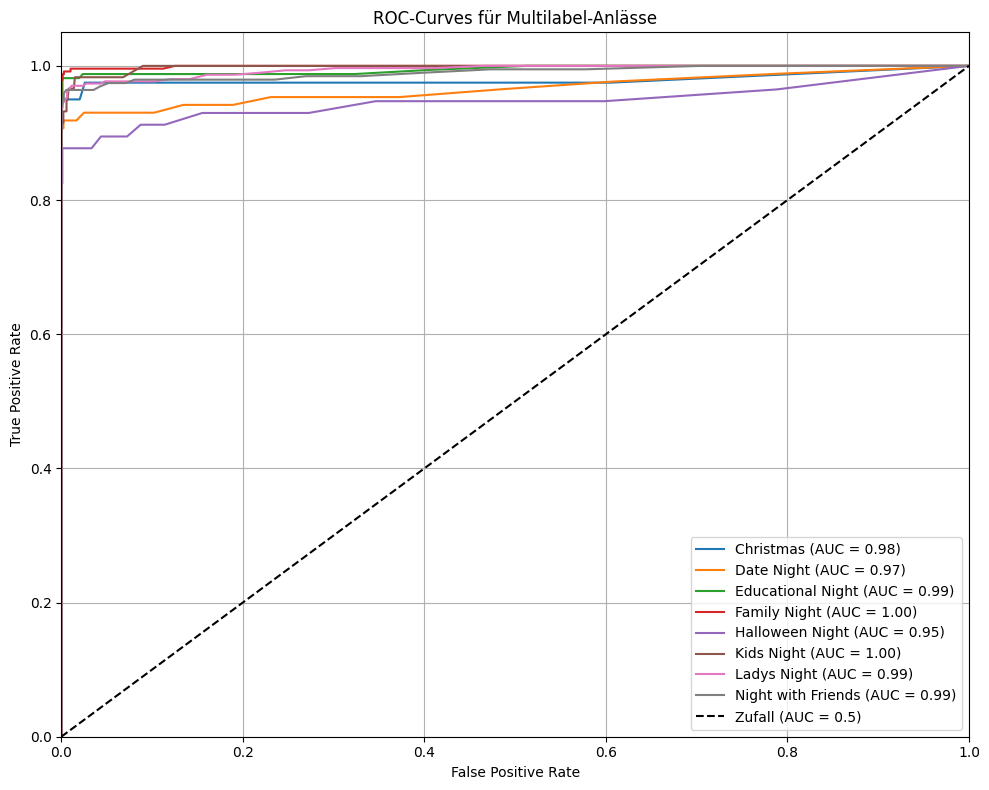


🧟 Fehleranalyse für: Halloween Night
❌ False Positives: 0
⚠️ False Negatives: 13

--- ❌ False Positives (vorhergesagt, aber falsch) ---
Empty DataFrame
Columns: [title, anlass_rule]
Index: []

--- ⚠️ False Negatives (nicht erkannt, aber richtig) ---
                                        title  \
150                  Mater and the Ghostlight   
1737  The Witcher: A Look Inside the Episodes   
2572                       The Little Vampire   
8358                       Monster Math Squad   
8805                       Rise of the Zombie   

                                            anlass_rule  
150                                   [Halloween Night]  
1737                                  [Halloween Night]  
2572                    [Halloween Night, Family Night]  
8358  [Night with Friends, Halloween Night, Ladys Ni...  
8805                                  [Halloween Night]  
✅ 5577 Filme wurden mit mehreren Anlässen ergänzt.


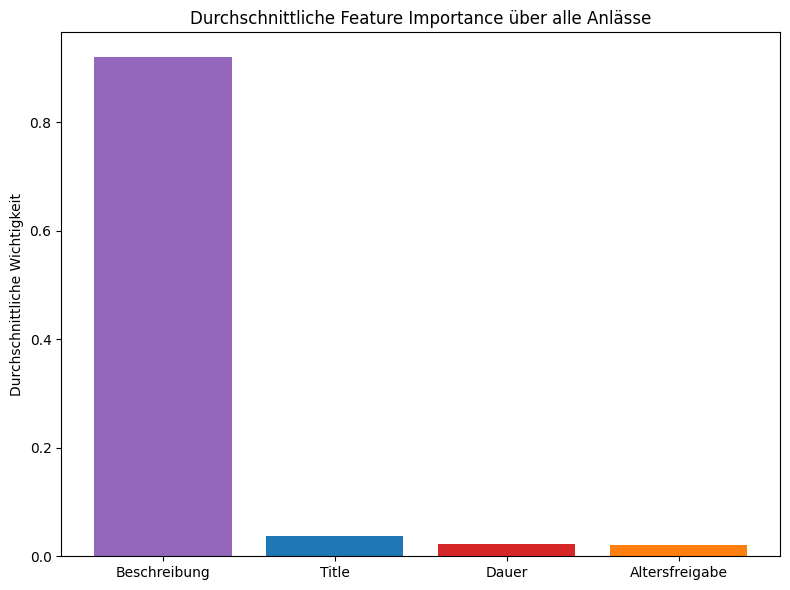

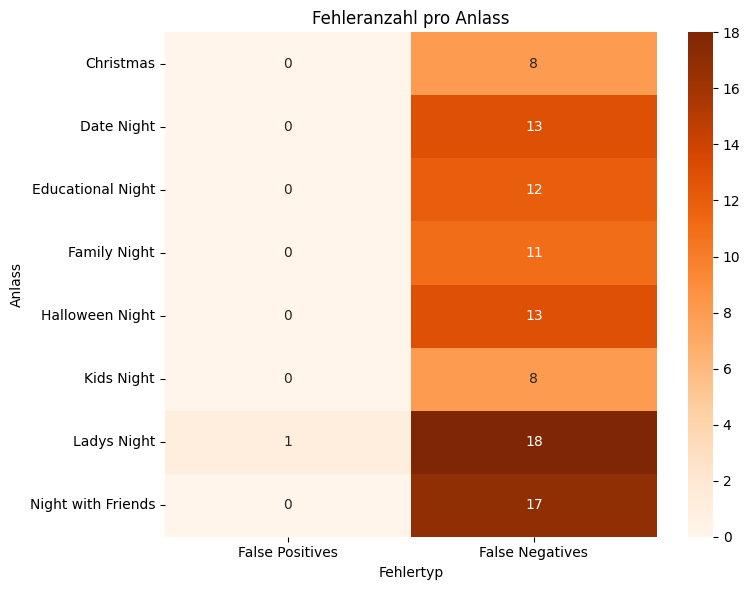

In [312]:
# 1. Modell trainieren
multi_model, mlb, y_test, y_pred = train_multilabel_anlass_model(df, tfidf_desc, tfidf_title)

# 2. Anwenden auf fehlende
df = apply_multilabel_model(df, multi_model, mlb, tfidf_desc, tfidf_title)

# Speichere das kombinierte DataFrame in einer neuen CSV-Datei
df.to_csv('../1_Datenset/erstellte/fertig/shows.csv', index=False)

# 3. Feature Importance plotten
plot_feature_importance_groups_avg(multi_model, desc_vectorizer, title_vectorizer)

# 4. Fehleranalyse

error_df = get_label_error_counts(y_test, y_pred, mlb)
plot_error_heatmap(error_df)

# Tuning

In [300]:

'''
# ✅ Nur Filme mit mind. einem Anlass
df_train = df[df["anlass_rule"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()

# Zielmatrix
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_train["anlass_rule"])

# Features
X = df_train[["title", "description", "duration_scaled", "agerating_scaled"]]

# 🧠 TF-IDF & numerische Features kombinieren
preprocessor = ColumnTransformer(transformers=[
    ("desc_tfidf", TfidfVectorizer(stop_words="english"), "description"),
    ("title_tfidf", TfidfVectorizer(stop_words="english"), "title"),
], remainder="passthrough")

# 🔁 Pipeline mit OneVsRest
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", OneVsRestClassifier(RandomForestClassifier(class_weight="balanced", random_state=42)))
])

# 🔍 Parametergrid
param_grid = {
    "preprocessor__desc_tfidf__max_features": [300, 500],
    "preprocessor__desc_tfidf__ngram_range": [(1, 1), (1, 2)],
    "preprocessor__title_tfidf__max_features": [300, 500],
    "preprocessor__title_tfidf__ngram_range": [(1, 1), (1, 2)],
    "clf__estimator__n_estimators": [100, 200],
    "clf__estimator__max_depth": [None, 10],
    "clf__estimator__min_samples_split": [2, 5]
}

# 🎯 Multilabel ROC-AUC (macro)
def macro_roc_auc_score(estimator, X_val, y_val):
    try:
        y_proba = estimator.predict_proba(X_val)
        return roc_auc_score(y_val, y_proba, average="macro")
    except:
        return 0.0


# 📊 Mehrere Scoring-Metriken definieren
scoring = {
    "f1_macro": make_scorer(f1_score, average="macro", zero_division=0),
    "roc_auc_macro": macro_roc_auc_score  # direkt die Funktion (kein make_scorer!)
}

# 🧪 GridSearchCV mit mehreren Metriken
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=scoring,
    refit="f1_macro",  # das finale Modell nutzt besten F1
    cv=3,
    verbose=2,
    n_jobs=-1
)

# ✅ Trainieren
grid_search.fit(X, y)

# Ergebnisse anzeigen
print("✅ Beste Parameterkombination:")
print(grid_search.best_params_)
print(f"🎯 Beste F1-Macro-Score (Multilabel): {grid_search.best_score_:.4f}")

# 🧠 ROC-AUC Ranking
results_df = pd.DataFrame(grid_search.cv_results_)
print("\n📈 ROC-AUC Scores (Top 5 Kombinationen):")
print(results_df[["mean_test_roc_auc_macro", "params"]].sort_values(by="mean_test_roc_auc_macro", ascending=False).head())

'''

'\n# ✅ Nur Filme mit mind. einem Anlass\ndf_train = df[df["anlass_rule"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()\n\n# Zielmatrix\nmlb = MultiLabelBinarizer()\ny = mlb.fit_transform(df_train["anlass_rule"])\n\n# Features\nX = df_train[["title", "description", "duration_scaled", "agerating_scaled"]]\n\n# 🧠 TF-IDF & numerische Features kombinieren\npreprocessor = ColumnTransformer(transformers=[\n    ("desc_tfidf", TfidfVectorizer(stop_words="english"), "description"),\n    ("title_tfidf", TfidfVectorizer(stop_words="english"), "title"),\n], remainder="passthrough")\n\n# 🔁 Pipeline mit OneVsRest\npipeline = Pipeline(steps=[\n    ("preprocessor", preprocessor),\n    ("clf", OneVsRestClassifier(RandomForestClassifier(class_weight="balanced", random_state=42)))\n])\n\n# 🔍 Parametergrid\nparam_grid = {\n    "preprocessor__desc_tfidf__max_features": [300, 500],\n    "preprocessor__desc_tfidf__ngram_range": [(1, 1), (1, 2)],\n    "preprocessor__title_tfidf__max_features": [3

🎯 F1-Macro (Multilabel): 0.9420
Das ist ein top Wert, insbesondere bei mehreren Labels pro Film.

📈 ROC-AUC Top-Werte (macro):
Bis zu 0.9857 – dein Modell unterscheidet sehr sicher zwischen Klassen.

✅ Beste Parameterkombination:
{'clf__estimator__max_depth': None, 
'clf__estimator__min_samples_split': 5, 
'clf__estimator__n_estimators': 200, 
'preprocessor__desc_tfidf__max_features': 500, 
'preprocessor__desc_tfidf__ngram_range': (1, 1), 
'preprocessor__title_tfidf__max_features': 300, 
'preprocessor__title_tfidf__ngram_range': (1, 1)}

🎯 Beste F1-Macro-Score (Multilabel): 0.9420

📈 ROC-AUC Scores (Top 5 Kombinationen):
    mean_test_roc_auc_macro                                             params
30                 0.985722  {'clf__estimator__max_depth': None, 'clf__esti...
62                 0.985634  {'clf__estimator__max_depth': None, 'clf__esti...
14                 0.985145  {'clf__estimator__max_depth': None, 'clf__esti...
46                 0.985057  {'clf__estimator__max_depth': None, 'clf__esti...
63                 0.984950  {'clf__estimator__max_depth': None, 'clf__esti...


### Interpretation der ROC-Kurve:
- AUC-Werte nahe 1.0 (z. B. Family Night, Kids Night) → Das Modell unterscheidet sehr gut zwischen positiv und negativ.
- AUC ≥ 0.95 bei allen Labels → Das Modell ist sehr performant für alle Anlässe.
- Die Zufallsgerade (AUC = 0.5) ist korrekt eingezeichnet → Referenzlinie
Das zeigt, dass deine Feature-Auswahl (Beschreibung, Titel, Dauer, Altersfreigabe) sehr gut funktioniert für dieses Setup.

Beispielhafte AUC-Übersicht:
| Anlass               | AUC  |
|----------------------|------|
| Family Night         | 1.00 |
| Kids Night           | 1.00 |
| Night with Friends   | 0.99 |
| Ladys Night          | 0.99 |
| Educational Night    | 0.99 |
| Christmas            | 0.98 |
| Date Night           | 0.97 |
| Halloween Night      | 0.95 |

Das zeigt, dass deine Feature-Auswahl (Beschreibung, Titel, Dauer, Altersfreigabe) sehr gut funktioniert für dieses Setup.

## Interpretation Fehleranalyse Halloween Night

### Ergebnis-Zusammenfassung:
🧟 Halloween Night

- ❌ False Positives: 0
    - Sehr gut! Das Modell sagt fast nie "Halloween Night", wenn’s nicht zutrifft.
- ⚠️ False Negatives: 13
    - Es übersieht einige Titel, die es eigentlich erkennen sollte.

### Beispielhafte False Negatives:
| Titel                  | Tatsächlicher Anlass                     |
|------------------------|------------------------------------------|
| Mater and the Ghostlight | [Halloween Night]                      |
| The Witcher: A Look Inside | [Halloween Night]                   |
| The Little Vampire     | [Halloween Night, Family Night]         |
| Monster Math Squad     | [Halloween, Friends, Ladys Night, Kids Night] |
| Rise of the Zombie     | [Halloween Night]                       |

### 💡 Interpretation:

Viele der False Negatives haben tatsächlich "Halloween-Vibes" (👻 Vampire, Zombies, Monster...).
Einige sind Kinder- oder Familienfilme, die vermutlich in den Features untergehen, weil sie nicht explizit als "Horror" getaggt sind.
Es könnte auch sein, dass die Beschreibung oder Titel nicht genug relevante Keywords enthalten.

### was man machen könnte:

1. False Negatives genauer analysieren

Checke z. B. die Beschreibung oder Plattformen – vielleicht enthalten sie nicht genug Halloween-relevante Wörter?

2. Regelbasiertes Labeling verbessern

→ Wenn du z. B. "ghostlight", "zombie", "witcher" usw. nicht in halloween_keywords hast, kannst du die Liste erweitern.

In [316]:
def build_feature_matrix(df: pd.DataFrame, vectorizer=None):
    if vectorizer is None:
        vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
        tfidf_matrix = vectorizer.fit_transform(df["combined_text"].fillna(""))
    else:
        tfidf_matrix = vectorizer.transform(df["combined_text"].fillna(""))

    numeric = df[["duration_scaled", "agerating_scaled"]].fillna(0)

    genre_cols = [col for col in df.columns if col.startswith("genre_") and df[col].dtype in [int, float]]
    platform_cols = [col for col in df.columns if col.startswith("platform_") and df[col].dtype in [int, float]]

    cat_features = df[genre_cols + platform_cols].fillna(0).astype(int)

    full_matrix = hstack([sp.csr_matrix(numeric.values), sp.csr_matrix(cat_features.values), tfidf_matrix])
    genre_matrix = sp.csr_matrix(df[genre_cols].values)

    return full_matrix, vectorizer, genre_matrix, tfidf_matrix

def recommend_by_favorite_show(show_name: str, df: pd.DataFrame, top_n: int = 5):
    df = df.copy()
    df['combined_text'] = df['combined_text'].fillna('')
    df['show_index'] = df.index

    feature_matrix, *_ = build_feature_matrix(df)

    titles = df['title'].tolist()
    matches = difflib.get_close_matches(show_name, titles)

    if not matches:
        return html.Div(f"❌ No matching title found for '{show_name}'.")

    selected_title = matches[0]
    index = df[df['title'] == selected_title].index[0]
    sim_scores = cosine_similarity(feature_matrix[index], feature_matrix).flatten()
    similar_indices = sim_scores.argsort()[::-1][1:top_n+1]

    recommendations = []
    for i, idx in enumerate(similar_indices, 1):
        row = df.loc[idx]

        title = row.get("title", "Unknown")
        content_type = row.get("type", "Unknown").capitalize()  # e.g. "Movie" or "TV Show"
        platform = str(row.get("platform", ""))
        genres_str = ", ".join(row["genre_list"]) if isinstance(row["genre_list"], list) else str(row.get("genre_list", ""))
        fsk = row.get("agerating", "n/a")
        if isinstance(fsk, list): fsk = ", ".join(map(str, fsk))
        duration = row.get("duration_minutes", "n/a")

        # Extras:
        platform_emoji = "🟥" if "Netflix" in platform else "🟦" if "Disney" in platform else "▶️"
        type_emoji = "🎬" if content_type == "Movie" else "📺"

        recommendations.append(html.Div([
            html.H5(f"{i}. 🎞️ {title}"),
            html.P(f"{platform_emoji} {platform} | {type_emoji}  {content_type} | 🎭 {genres_str}"),
            html.P(f"🧒 FSK: {fsk} | ⏱ {duration} min"),
            html.Hr()
        ]))


    return html.Div([
        html.P(f"🔍 Did you mean: {selected_title}?"),
        html.Ul(recommendations)
    ])

In [317]:
def build_virtual_user_vector(age, platform, anlasse, genres, keywords, df_template, vectorizer):
    user_input = {
        "duration_scaled": 0.5,
        "agerating_scaled": age / 18.0
    }

    platforms = ["Netflix", "Disney+"] if platform == "both" else [platform]

    for col in df_template.columns:
        if col.startswith("platform_"):
            name = col.replace("platform_", "")
            user_input[col] = 1 if name in platforms else 0

    for col in df_template.columns:
        if col.startswith("genre_") and ".1" not in col:
            name = col.replace("genre_", "")
            user_input[col] = 1 if name in genres else 0

    user_input["combined_text"] = " ".join(genres + platforms + anlasse + keywords)

    user_df = pd.DataFrame([user_input])
    combined_df = pd.concat([user_df, df_template.iloc[:1]], ignore_index=True)

    full_matrix, _, genre_matrix, tfidf_matrix = build_feature_matrix(combined_df, vectorizer)

    return {
        "combined_vector": full_matrix[0],
        "genre_vector": genre_matrix[0],
        "tfidf_vector": tfidf_matrix[0]
    }

def recommend_by_user_input(age, platform, anlasse, genres, keywords, duration, df, top_n=10):
    df = df.copy()
    df["combined_text"] = df["combined_text"].fillna("")

    allowed_platforms = ["Netflix", "Disney+"] if platform == "both" else [platform]
    df = df[df["platform_list"].apply(lambda x: any(p in x for p in allowed_platforms))]
    df = df[df["agerating_encoded"] <= age]

    if duration:
        if "<60" in duration:
            df = df[df["duration_minutes"] < 60]
        elif "60-100" in duration:
            df = df[(df["duration_minutes"] >= 60) & (df["duration_minutes"] <= 100)]
        elif ">100" in duration:
            df = df[df["duration_minutes"] > 100]

    if df.empty:
        return html.Div("❌ No movies found with these filters.")
    
    full_matrix, _, genre_matrix, tfidf_matrix = build_feature_matrix(df, vectorizer=global_vectorizer)
    user_vectors = build_virtual_user_vector(age=age, platform=platform, anlasse=anlasse, genres=genres, keywords=keywords, df_template=df, vectorizer=global_vectorizer)


    sim_anlass = cosine_similarity(user_vectors["tfidf_vector"], tfidf_matrix).flatten()
    sim_genre = cosine_similarity(user_vectors["genre_vector"], genre_matrix).flatten()
    sim_keywords = cosine_similarity(user_vectors["tfidf_vector"], tfidf_matrix).flatten()

    score = (
        0.7 * sim_anlass +
        0.4 * sim_genre +
        0.5 * sim_keywords
    )
    score = score / (0.7 + 0.4 + 0.5)

    top_indices = score.argsort()[::-1][:top_n]

    recommendations = []
    for i, idx in enumerate(top_indices, 1):
        row = df.iloc[idx]

        title = row.get("title", "Unknown")
        content_type = row.get("type", "Unknown").capitalize()  # e.g. "Movie" or "TV Show"
        platform = str(row.get("platform", ""))
        genres_str = ", ".join(row["genre_list"]) if isinstance(row["genre_list"], list) else str(row.get("genre_list", ""))
        fsk = row.get("agerating", "n/a")
        if isinstance(fsk, list): fsk = ", ".join(map(str, fsk))
        duration = row.get("duration_minutes", "n/a")

        # Extras:
        platform_emoji = "🟥" if "Netflix" in platform else "🟦" if "Disney" in platform else "▶️"
        type_emoji = "🎬" if content_type == "Movie" else "📺"

        recommendations.append(html.Div([
            html.H5(f"{i}. 🎞️ {title}"),
            html.P(f"{platform_emoji} {platform} | {type_emoji}  {content_type} | 🎭 {genres_str}"),
            html.P(f"🧒 FSK: {fsk} | ⏱ {duration} min"),
            html.Hr()
        ]))

    return html.Ul(recommendations)

# UI

In [318]:
import dash
from dash import html, dcc, Input, Output, State
import dash_bootstrap_components as dbc
import pandas as pd
from dash import callback_context

# --- Optionen für UI ---
occasion_options = [
    "Christmas", "Halloween Night", "Date Night", "Ladys Night",
    "Family Night", "Kids Night", "Night with Friends", "Educational Night"
]

all_genres = sorted([
    "Comedy", "Action & Adventure", "Romance", "Animation",
    "Documentary", "Drama", "Sci-Fi & Fantasy", "Children & Family",
    "Horror", "Music & Musicals", "Thriller & Crime"
])

# --- Dash Setup ---
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP], suppress_callback_exceptions=True)
server = app.server

# --- Layout ---
# --- Immer im Layout: beide Modi sichtbar, aber per CSS ein-/ausblendbar ---
app.layout = html.Div([
    html.H2("🎬 Personalized Movie Recommendation"),

    html.Label("✨ Recommendation type:"),
    dcc.RadioItems(
        id="mode",
        options=[
            {"label": "Based on an occasion", "value": "occasion"},
            {"label": "Based on favorite movie", "value": "favorite_movie"},
        ],
        value="occasion",
        labelStyle={"margin-right": "15px"}
    ),

    html.Br(),

    html.Div(id="occasion-form", children=[
        dbc.Row([
            dbc.Col([
                html.Label("👤 Age (Max FSK):"),
                dcc.Input(id="age", type="number", min=0, max=18, value=12)
            ]),
            dbc.Col([
                html.Label("📺 Platform:"),
                dcc.Dropdown(
                    id="platform",
                    options=[
                        {"label": "Netflix", "value": "Netflix"},
                        {"label": "Disney+", "value": "Disney+"},
                        {"label": "Both", "value": "both"},
                    ],
                    value="both"
                )
            ]),
            dbc.Col([
                html.Label("⏱ Duration:"),
                dcc.RadioItems(
                    id="duration",
                    options=[
                        {"label": "< 60 min", "value": "<60"},
                        {"label": "60–100 min", "value": "60-100"},
                        {"label": "> 100 min", "value": ">100"},
                    ],
                    value="60-100"
                )
            ])
        ]),
        html.Br(),
        html.Label("🎉 Occasion(s):"),
        dcc.Dropdown(
            id="occasions",
            options=[{"label": o, "value": o} for o in occasion_options],
            multi=True
        ),

        html.Label("🎭 Favorite genres:"),
        dcc.Dropdown(
            id="genres",
            options=[{"label": g, "value": g} for g in all_genres],
            multi=True
        ),

        html.Label("🔍 Keywords (comma-separated):"),
        dcc.Input(id="keywords", type="text", debounce=True, style={"width": "100%"})
    ]),

    html.Div(id="favorite-form", children=[
        html.Label("🎥 Enter your favorite movie:"),
        dcc.Input(id="favorite_movie", type="text", style={"width": "100%"})
    ]),

    html.Br(),
    dbc.Button("Show Recommendation", id="submit", color="primary"),
    html.Br(), html.Br(),
    html.Div(id="output")
])

# --- Dynamische ein und asublenden ---
@app.callback(
    Output("occasion-form", "style"),
    Output("favorite-form", "style"),
    Input("mode", "value")
)
def toggle_forms(mode):
    if mode == "occasion":
        return {}, {"display": "none"}
    else:
        return {"display": "none"}, {}


# --- Callback für Empfehlung ---
@app.callback(
    Output("output", "children"),
    Input("submit", "n_clicks"),
    State("mode", "value"),
    State("age", "value"),
    State("platform", "value"),
    State("occasions", "value"),
    State("genres", "value"),
    State("keywords", "value"),
    State("duration", "value"),
    State("favorite_movie", "value"),
)
def update_recommendation(n_clicks, mode, age, platform, occasions, genres, keywords, duration, favorite_movie):
    if not n_clicks:
        return ""

    # Nur relevante States je nach Modus verwenden
    try:
        if mode == "occasion":
            keywords_list = [k.strip() for k in (keywords or "").split(",") if k.strip()]
            return recommend_by_user_input(
                age=age or 12,
                platform=platform or "both",
                anlasse=occasions or [],
                genres=genres or [],
                keywords=keywords_list,
                duration=duration or "60-100",
                df=df,
                top_n=10
            )

        elif mode == "favorite_movie":
            if not favorite_movie:
                return "❗ Please enter a movie title."
            return recommend_by_favorite_show(favorite_movie, df, top_n=10)

    except Exception as e:
        return f"❌ Error: {e}"



# --- App starten ---
if __name__ == "__main__":
    app.run_server(debug=True, port=8051)
